In [1]:
import os
import numpy as np
import random
from PIL import Image, ImageEnhance

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense,Flatten,Dropout
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle

In [2]:
train_dir = "/Users/subra/Downloads/braintumor/Training"
test_dir = "/Users/subra/Downloads/braintumor/Testing"

In [3]:
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir,label)):
        train_paths.append(os.path.join(train_dir,label,image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths,train_labels)

test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir,label)):
        test_paths.append(os.path.join(test_dir,label,image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths,test_labels)

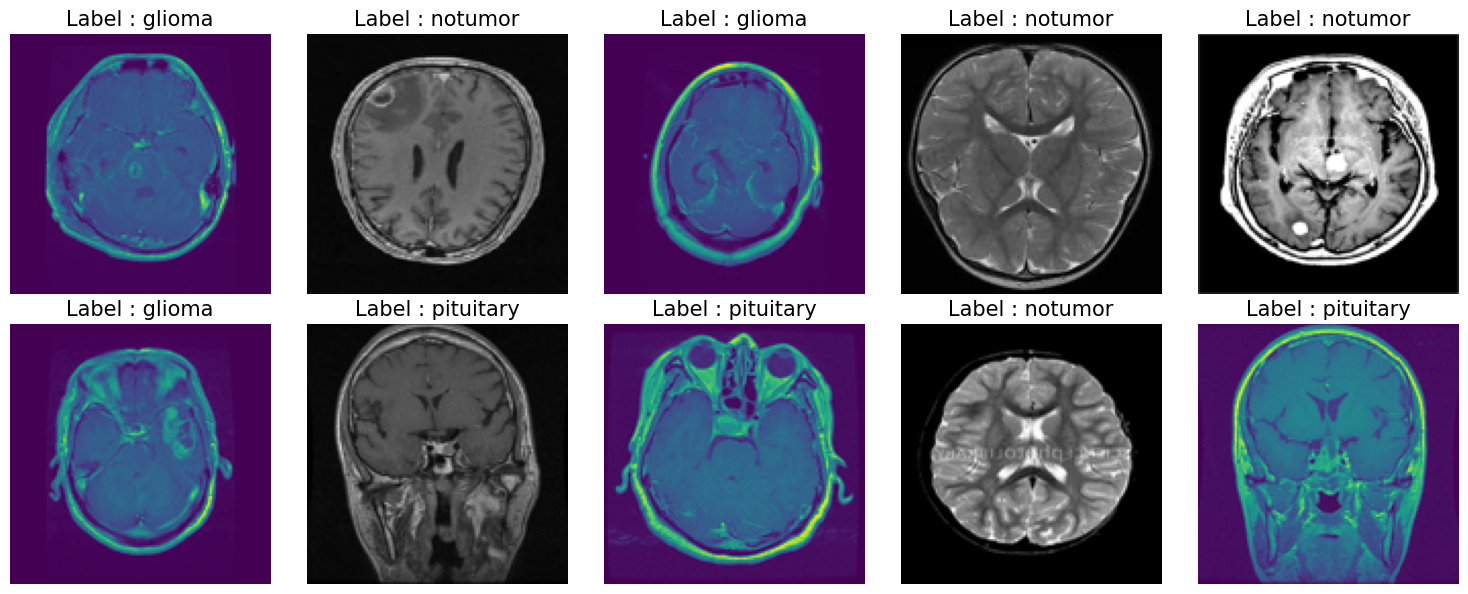

In [4]:
import matplotlib.pyplot as plt
random_indices = random.sample(range(len(train_paths)),10)
fig, axes = plt.subplots(2,5, figsize = (15,6))
axes = axes.ravel()
for i, idx in enumerate(random_indices):
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((128,128))
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"Label : {train_labels[idx]}",fontsize = 15)
plt.tight_layout()
plt.show()

In [5]:
if 'IMAGE_SIZE' not in locals():
    IMAGE_SIZE = 128 

if 'batch_size' not in locals():
    batch_size = 32

if 'epochs' not in locals():
    epochs = 10

def augmentation_image(image):
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image, dtype=np.float32) / 255.0
    return image

def open_image(paths):
    images = []
    for path in paths:
        img = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        img = augmentation_image(img)
        images.append(img)
    return np.array(images)

def encode_label(labels):
    unique_labels = os.listdir(train_dir)
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

def datagen(paths, labels, batch_size, epochs):
    while True:
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]
            batch_images = [augmentation_image(load_img(p, target_size=(IMAGE_SIZE, IMAGE_SIZE))) for p in batch_paths]
            yield np.array(batch_images), np.array(batch_labels)

train_labels = np.array(train_labels).reshape(-1)


for batch_images, batch_labels in datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs):
    print(f"Batch images shape: {batch_images.shape}")
    print(f"Batch labels shape: {batch_labels.shape}")
    break

Batch images shape: (32, 128, 128, 3)
Batch labels shape: (32,)


In [6]:
len(train_paths), len(train_labels), len(test_paths), len(test_labels)
print(f"Number of training images: {len(train_paths)}")
print(f"Number of training labels: {len(train_labels)}")
print(f"Number of testing images: {len(test_paths)}")
print(f"Number of testing labels: {len(test_labels)}")

Number of training images: 5712
Number of training labels: 5712
Number of testing images: 1311
Number of testing labels: 1311


In [7]:
IMAGE_SIZE = 128
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable=False

base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(len(os.listdir(train_dir)),activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

batch_size = 20
steps=int(len(train_paths)/batch_size)
epochs= 5

unique_labels = sorted(set(train_labels))
label2idx = {label: idx for idx, label in enumerate(unique_labels)}
train_labels = np.array([label2idx[label] for label in train_labels])

history = model.fit(
    datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
    epochs=epochs,
    steps_per_epoch=steps,  
)

Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 297s 1s/step - loss: 0.4582 - sparse_categorical_accuracy: 0.8247
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 223s 782ms/step - loss: 0.2183 - sparse_categorical_accuracy: 0.9197
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 317s 1s/step - loss: 0.1547 - sparse_categorical_accuracy: 0.9418
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 251s 879ms/step - loss: 0.1028 - sparse_categorical_accuracy: 0.9617
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 234s 822ms/step - loss: 0.0709 - sparse_categorical_accuracy: 0.9747


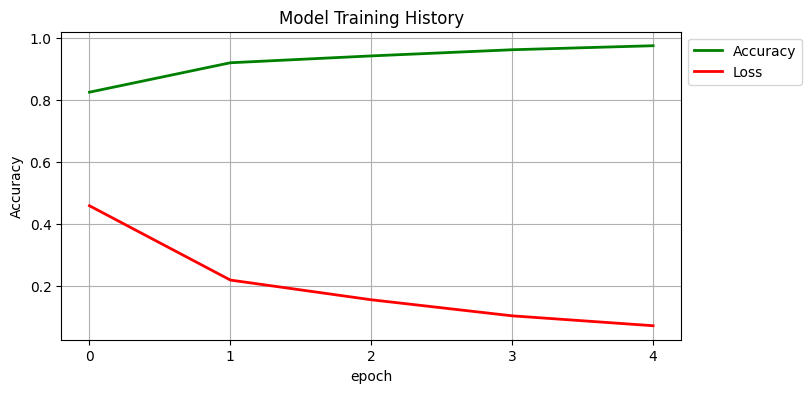

In [8]:
plt.figure(figsize=(8, 4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '-g', linewidth=2)
plt.plot(history.history['loss'], '-r', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc,accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
import numpy as np

test_images = open_image(test_paths)
# Properly encode all test labels
label2idx = {label: idx for idx, label in enumerate(os.listdir(train_dir))}
test_labels_encoded = np.array([label2idx[label] for label in test_labels])
test_predictions = model.predict(test_images)

print("Classification Report")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 999ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       300
           1       0.95      0.89      0.92       306
           2       0.99      0.99      0.99       405
           3       1.00      0.94      0.97       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.96      0.95      0.95      1311



confusion Matrix:
[[293   7   0   0]
 [ 31 271   4   0]
 [  2   1 402   0]
 [ 11   5   1 283]]


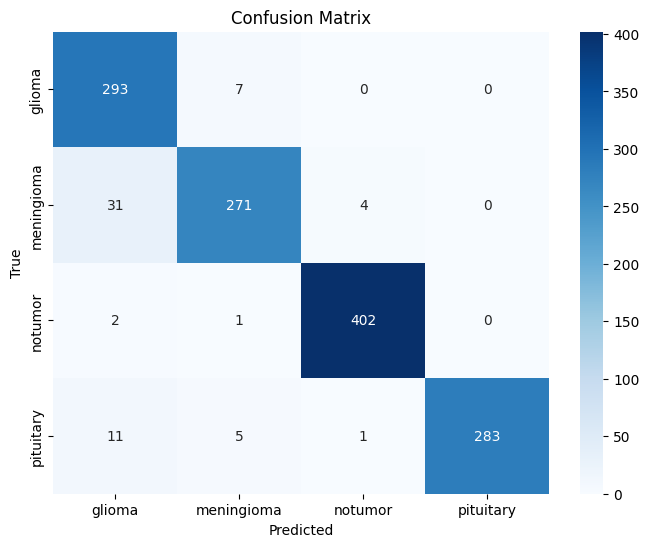

In [10]:
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions,axis=1))
print("confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d',cmap='Blues',xticklabels=os.listdir(train_dir),yticklabels=os.listdir(train_dir))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

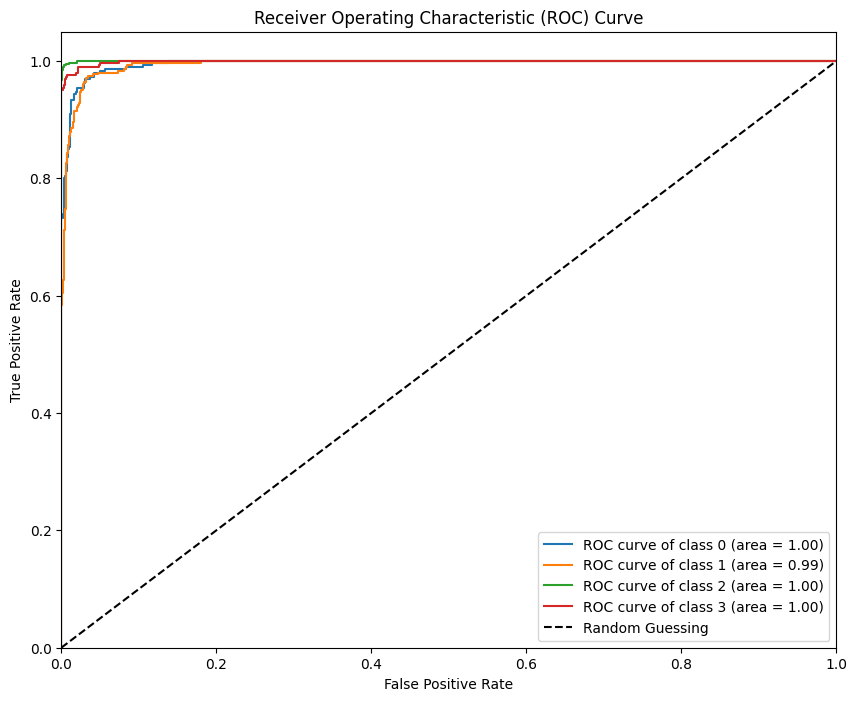

In [11]:
#ROC Curve
test_labels_binarized = label_binarize(test_labels_encoded, classes=list(label2idx.values()))
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(label2idx)):
    fpr[i], tpr[i], _ = roc_curve(test_labels_binarized[:, i], test_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(10, 8))
for i in range(len(label2idx)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [12]:
#AUC
auc_score = accuracy_score(test_labels_encoded, np.argmax(test_predictions, axis=1))
print(f"AUC Score: {auc_score:.2f}") 

AUC Score: 0.95


In [13]:
model.save('my__model.h5')

In [14]:
from tensorflow.keras.models import load_model
mymodel = load_model('my__model.h5')

In [15]:
from tensorflow.keras.preprocessing.image import img_to_array

class_labels = ['glioma','meningioma','notumor','pituitary']

def detect_and_display(image_path, mymodel):
    try:
        #load image
        img = load_img(image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array /= 255.0  # Normalize pixel values

        # Make predictions
        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions)
        predicted_class_index = np.argmax(predictions)
        confidence_score = np.max(predictions,axis=1)[0]

        #Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"
        
        #Display
        plt.imshow(load_img(image_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score:.2f})%")

    except Exception as e:
        print(f"Error processing image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


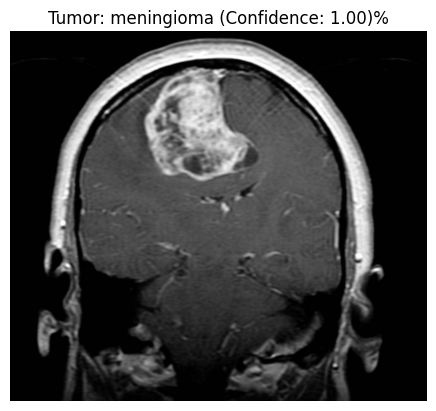

In [16]:
image_path = r"C:\Users\subra\Downloads\braintumor\Testing\meningioma\Te-me_0066.jpg"
detect_and_display(image_path,mymodel)